<a href="https://colab.research.google.com/github/XBACTYN/DB_Anomaly_Detection/blob/master/neural2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import json
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import torch
import torch.nn as nn
from keras.models import Model
from tensorflow import keras
from keras import backend as K
from sklearn.metrics import confusion_matrix
system_random = random.SystemRandom()
qvector_source_train ='/content/drive/MyDrive/data/GENERATED_classic_vectors_train.json'
qvector_source_test ='/content/drive/MyDrive/data/GENERATED_classic_vectors_test.json'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cnn_lstm = keras.Sequential()
cnn_lstm.add(keras.layers.Input((309,1)))
cnn_lstm.add(keras.layers.Conv1D(64, kernel_size=2, padding='same',activation='tanh'))
cnn_lstm.add(keras.layers.Conv1D(64, kernel_size=2, padding='same',activation='tanh'))
cnn_lstm.add(keras.layers.MaxPool1D(2,padding='same'))
#cnn_lstm.add(keras.layers.Flatten())
cnn_lstm.add(keras.layers.LSTM(50, activation='relu'))
cnn_lstm.add(Dropout(rate=0.2))
cnn_lstm.add(keras.layers.Flatten())
cnn_lstm.add(keras.layers.Dense(124,activation='relu'))
cnn_lstm.add(keras.layers.Dense(11,activation='softmax'))

cnn_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss ='mse',metrics=['accuracy'])
cnn_lstm.summary()

In [ ]:
cnn = keras.Sequential()
cnn.add(keras.layers.Input((6180,1)))
#cnn.add(keras.layers.Normalization(axis=None))
cnn.add(keras.layers.Conv1D(64,2,padding='same',activation='tanh'))
cnn.add(keras.layers.Conv1D(64,2,padding='same',activation='tanh'))
cnn.add(keras.layers.Conv1D(64,2,padding='same',activation='tanh'))
cnn.add(keras.layers.MaxPool1D(2,padding='same'))
cnn.add(keras.layers.Flatten())
cnn.add(keras.layers.Dense(256,activation='relu'))
cnn.add(keras.layers.Dense(11,activation='softmax'))

cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss ='categorical_crossentropy',metrics=['accuracy'])
cnn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 6180, 64)          192       
                                                                 
 conv1d_21 (Conv1D)          (None, 6180, 64)          8256      
                                                                 
 conv1d_22 (Conv1D)          (None, 6180, 64)          8256      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 3090, 64)         0         
 1D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 197760)            0         
                                                                 
 dense_12 (Dense)            (None, 256)               50626816  
                                                      

In [ ]:
def convertor(arr):
  result = np.zeros((len(arr),11))
  for i in range(0,len(result)):
    result[i,arr[i]-1]=1.0
  return result

In [ ]:
def unpack_data(path):
    #transactions_list = []
    role_list = []
    query_list = []
    f = open(path, 'r', encoding='utf-8')
    data = json.load(f)
    print('len data ',len(data))
    for i in range(0,len(data)):
        #transactions_list.append(data[i].get('transaction'))
        role_list.append(data[i].get('role'))
        query_list.append(np.array(list(map(float,data[i].get('query')))))
    
    X = np.array(query_list)
    y = np.array(role_list)
    print(X)
    print(y)
    print(len(X))
    #print(transactions_list)
    print('unpacked')
    return X,y

In [ ]:
def make_anomalies(y_test,percent):
    list1 = [1,2,3,4,5,6,7,8,9,10,11]
    count = int(len(y_test)*percent/100)
    print(f'Будет заменено {count}  первых значений ролей из {len(y_test)}, процент измененных {percent}.')
    y_test_anomalies = y_test.copy()
    for i in range(0,count):
        list2 = list1.copy()
        list2.remove(y_test_anomalies[i])
        y_test_anomalies[i] = system_random.choice(list2)
    return y_test_anomalies,count

In [ ]:
def loss_plt(history):
  loss_values = history.history['loss']
  epochs = range(1, len(loss_values)+1)

  plt.plot(epochs, loss_values, label='Потери на обучающей выборке')
  plt.xlabel('Эпохи')
  plt.ylabel('Потери')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/data/results/loss_resnet_classic.png')
  plt.show()

In [ ]:
def accuracy_plt(history):
  acc_values = history.history['accuracy']
  epochs = range(1, len(acc_values)+1)

  plt.plot(epochs, acc_values, label='Точность на обучающей выборке',color='orange')
  plt.xlabel('Эпохи')
  plt.ylabel('Точность')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/data/results/accuracy_resnet_classic.png')
  plt.show()

In [ ]:
def plot_confusion_matrix(y_true,y_pred,name,vector_type):
    fig, ax = plt.subplots(figsize=(10,10))
    cf_matrix = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(cf_matrix, annot=True, cmap='OrRd')

    ax.set_title(' Матрица ошибок')
    ax.set_xlabel('Предсказанные значения классов')
    ax.set_ylabel(f'{name} значения классов')

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes)
    fig.savefig(f'{result_path}{vector_type}_confus_{name}_resnet_classic.png')

In [ ]:
classes = [1,2,3,4,5,6,7,8,9,10,11]
result_path = '/content/drive/MyDrive/data/results/'
X_train,y_train = unpack_data(qvector_source_train)
Q_DATA_LEN = len(y_train)
Q_VECTOR_LEN = len(X_train[0])
print(np.max(X_train,axis=1))
X_test, y_test = unpack_data(qvector_source_test)
y_train =  convertor(y_train)
Q_TEST_LEN=len(y_test)

len data  110069
[[  1. 109.   1. ...   1.   0.   0.]
 [  1.  61.   1. ...   2.   0.   1.]
 [  1.  98.   1. ...   0.   0.   1.]
 ...
 [  1. 318.   1. ...   0.   0.   1.]
 [  1. 304.   1. ...   1.   0.   1.]
 [  1. 179.   1. ...   2.   0.   1.]]
[ 1  1  1 ... 11 11 11]
110069
unpacked
[1.0900000e+02 6.1000000e+01 9.8000000e+01 ... 4.6700000e+02 1.2723526e+07
 2.5800000e+02]
len data  11017
[[  1. 115.   1. ...   0.   0.   0.]
 [  1.  99.   1. ...   2.   0.   1.]
 [  1.  67.   1. ...   0.   0.   0.]
 ...
 [  1. 173.   1. ...   2.   0.   1.]
 [  3. 197.   0. ...   8.   0.   4.]
 [  1. 254.   1. ...   1.   0.   1.]]
[ 1  1  1 ... 11 11 11]
11017
unpacked


In [ ]:
y_test_anomalies,anomalies_count = make_anomalies(y_test,25)

Будет заменено 2754  первых значений ролей из 11017, процент измененных 25.


In [ ]:
norm = keras.layers.Normalization(axis=None)
norm.adapt(X_train.reshape((Q_DATA_LEN,Q_VECTOR_LEN,1)))
history = cnn.fit(norm(X_train.reshape((Q_DATA_LEN,Q_VECTOR_LEN,1))),y_train,epochs =20,shuffle=False)


Epoch 1/20
344/344 [==============================] - 16s 40ms/step - loss: 1.1097 - accuracy: 0.6095
Epoch 2/20
344/344 [==============================] - 14s 40ms/step - loss: 0.5823 - accuracy: 0.7930
Epoch 3/20
344/344 [==============================] - 13s 39ms/step - loss: 0.3587 - accuracy: 0.8646
Epoch 4/20
344/344 [==============================] - 13s 39ms/step - loss: 0.2385 - accuracy: 0.9102
Epoch 5/20
344/344 [==============================] - 13s 39ms/step - loss: 0.1639 - accuracy: 0.9390
Epoch 6/20
344/344 [==============================] - 13s 39ms/step - loss: 0.1108 - accuracy: 0.9556
Epoch 7/20
344/344 [==============================] - 13s 39ms/step - loss: 0.0966 - accuracy: 0.9649
Epoch 8/20
344/344 [==============================] - 13s 39ms/step - loss: 0.0707 - accuracy: 0.9735
Epoch 9/20
344/344 [==============================] - 13s 39ms/step - loss: 0.0552 - accuracy: 0.9798
Epoch 10/20
344/344 [==============================] - 13s 39ms/step - loss: 0.040

In [ ]:
y_pred = cnn.predict(X_test.reshape((Q_TEST_LEN,Q_VECTOR_LEN,1,1)))
y=(np.argmax(y_pred,axis=1)+1)
print(*y)
m= keras.metrics.Accuracy()
m.update_state(y_test,(np.argmax(y_pred,axis=1)+1))
m.result().numpy()

35/35 [==============================] - 1s 14ms/step
1 2 3 4 5 6 7 8 9 10 11 1 2 3 4 5 6 8 8 9 10 11 1 9 3 3 5 6 7 8 9 10 11 1 2 3 4 5 6 7 8 9 10 11 1 2 3 3 5 10 7 8 9 10 7 1 2 3 3 5 6 7 8 9 10 11 1 2 3 4 5 6 7 8 9 10 11 1 2 3 4 5 6 7 5 9 10 11 1 3 3 4 5 6 7 8 9 10 11 1 2 3 3 5 6 7 8 9 10 11 1 2 3 4 5 6 7 8 9 10 11 1 2 3 3 5 6 7 8 9 10 11 1 2 3 4 5 10 7 8 9 10 11 1 2 3 4 5 6 7 8 9 10 11 1 2 3 3 5 6 7 8 9 10 11 1 2 3 4 5 10 7 8 9 10 11 1 2 3 4 5 6 7 8 9 10 11 1 2 3 4 5 10 7 8 9 10 11 1 2 3 4 5 10 7 8 9 10 11 1 2 3 4 5 6 7 8 9 10 11 1 9 3 3 5 10 7 8 9 10 11 1 2 3 3 5 10 7 8 9 10 11 1 2 3 4 5 6 7 8 9 10 11 1 2 3 4 5 6 7 8 9 10 11 1 2 3 4 5 10 7 8 9 10 7 1 9 3 4 5 6 7 8 9 10 11 1 2 3 3 5 6 7 8 9 10 11 1 2 3 4 5 6 7 8 9 10 11 1 2 3 4 5 6 7 8 9 10 11 1 2 3 4 5 6 7 8 9 10 11 1 2 3 3 5 6 7 8 9 10 11 1 2 3 8 5 6 7 8 9 10 11 1 2 3 4 5 6 7 8 9 10 11 1 2 3 3 5 6 7 8 9 10 11 1 2 3 3 5 10 7 8 9 10 11 1 2 3 4 5 6 7 8 9 10 11 1 2 3 4 5 6 7 8 9 10 11 1 2 3 4 5 6 7 8 9 10 11 1 2 3 3 5 6 7 8 9 10 11 1 2

0.92545456

In [ ]:
diff_values = sum(el1 !=el2 for el1,el2 in zip(y[:anomalies_count],y_test_anomalies[:anomalies_count]))
print(diff_values)
detection_rate = (diff_values/anomalies_count)*100
print('detection rate ',detection_rate)

273
detection rate  99.27272727272727


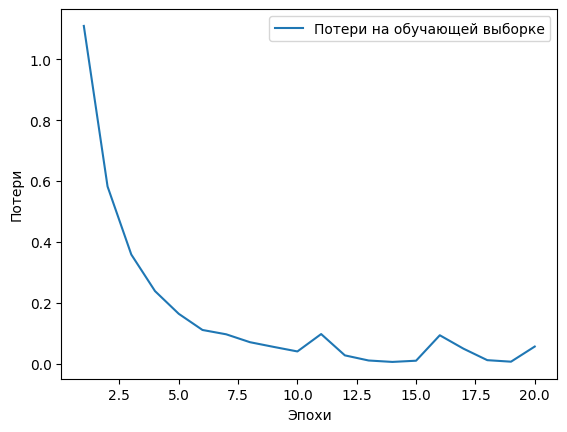

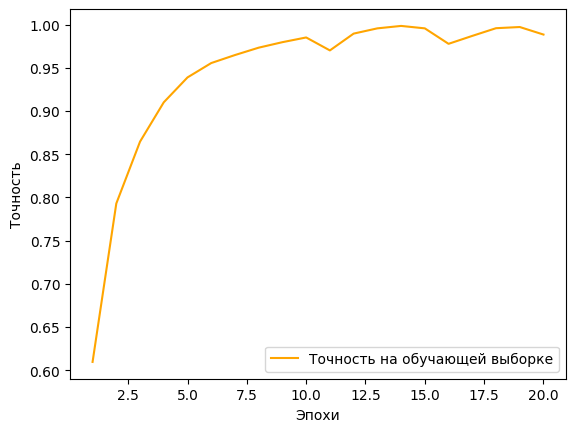

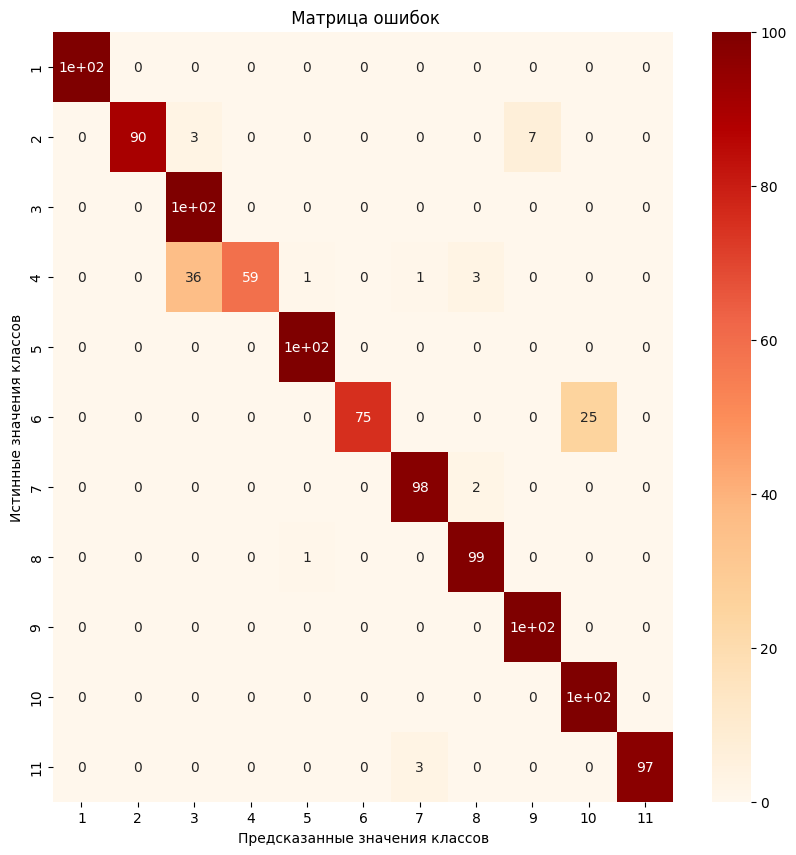

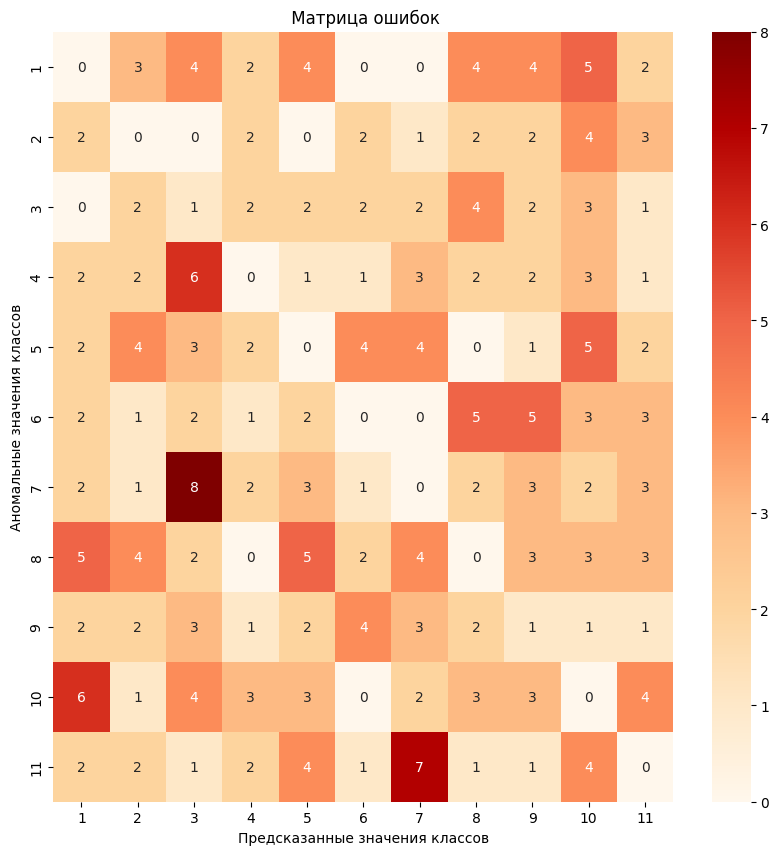

In [ ]:
loss_plt(history)
accuracy_plt(history)

plot_confusion_matrix(y_test,y,'Истинные','quiplet')
plot_confusion_matrix(y_test_anomalies[:anomalies_count],y[:anomalies_count],'Аномальные','quiplet')


In [ ]:
norm = keras.layers.Normalization(axis=None)
norm.adapt(X_train.reshape((Q_DATA_LEN,Q_VECTOR_LEN,1)))
cnn_lstm.fit(norm(X_train.reshape((Q_DATA_LEN,Q_VECTOR_LEN,1))),y_train,epochs =10)

In [ ]:
class ResConnect(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(ResConnect, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.tanh = nn.Tanh()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=2, stride=1)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=2, stride=1)
        self.conv3 = nn.Conv1d(out_channels, out_channels, kernel_size=2, stride=1)
        self.conv4 = nn.Conv1d(out_channels, out_channels, kernel_size=2, stride=1)

    def forward(self, inp):
        out = inp
        out = self.conv1(out)
        out = self.tanh(out)
        out = self.conv2(out)
        out = self.tanh(out)
        out = self.conv3(out)
        out = self.tanh(out)
        out = self.conv4(out)
        out = out + inp
        out = self.tanh(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Block1 = nn.Sequential(nn.Conv1d(1, 32, kernel_size=2, stride=1),
                                    nn.Tanh(),
                                    )
        self.ResBlock1 = ResConnect(32, 32)
        self.ResBlock2 = ResConnect(32, 32)

        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=1)

        self.Classifier = nn.Sequential(nn.Linear(100, 256),
                                        nn.ReLU(inplace=True),
                                        nn.Linear(256, 11),
                                        nn.Softmax(),
                                        )

    def forward(self, x):
        out = x
        out = self.Block1(out)
        out = self.ResBlock1(out)
        out = self.ResBlock2(out)
        out = self.maxpool(out)
        out = self.Classifier(out)
        return out

In [ ]:
input = keras.layers.Input((Q_VECTOR_LEN,1))
o1 =keras.layers.Conv1D(32,2,padding='same',activation='tanh')(input)

o2 =keras.layers.Conv1D(32,2,padding='same',activation='tanh')(o1)
o3=keras.layers.Conv1D(32,2,padding='same',activation='tanh')(o2)
o4=keras.layers.Conv1D(32,2,padding='same',activation='tanh')(o3)
o5=keras.layers.Conv1D(32,2,padding='same')(o4)
#out2 = res.layers[4].output + out
o15 = keras.activations.tanh(o1+o5)
o6=keras.layers.Conv1D(32,2,padding='same',activation='tanh')(o15)
o7=keras.layers.Conv1D(32,2,padding='same',activation='tanh')(o6)
o8=keras.layers.Conv1D(32,2,padding='same',activation='tanh')(o7)
o9=keras.layers.Conv1D(32,2,padding='same')(o8)
o159 = keras.activations.tanh(o1+o5+o9)
o10=keras.layers.MaxPool1D(2,padding='same')(o159)
o11=keras.layers.Flatten()(o10)
o15=keras.layers.Dense(256,activation='relu')(o11)
o16=keras.layers.Dense(11,activation='softmax')(o15)

model = tf.keras.Model(inputs=input, outputs=o16)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss ='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 309, 1)]     0           []                               
                                                                                                  
 conv1d_207 (Conv1D)            (None, 309, 32)      96          ['input_24[0][0]']               
                                                                                                  
 conv1d_208 (Conv1D)            (None, 309, 32)      2080        ['conv1d_207[0][0]']             
                                                                                                  
 conv1d_209 (Conv1D)            (None, 309, 32)      2080        ['conv1d_208[0][0]']             
                                                                                           

In [ ]:
norm = keras.layers.Normalization(axis=None)
norm.adapt(X_train.reshape((Q_DATA_LEN,Q_VECTOR_LEN,1)))
history2 = model.fit(norm(X_train.reshape((Q_DATA_LEN,Q_VECTOR_LEN,1))),y_train,epochs =5,shuffle=False)
# for i in range(0,10):
#   history2 = model.fit(norm(X_train.reshape((Q_DATA_LEN,Q_VECTOR_LEN,1))),y_train,epochs =1,shuffle=False)
#   y_pred=model.predict(X_test.reshape((Q_TEST_LEN,Q_VECTOR_LEN,1,1)))
#   y=(np.argmax(y_pred,axis=1)+1)
#   print(*y)
#   m= keras.metrics.Accuracy()
#   m.update_state(y_test,(np.argmax(y_pred,axis=1)+1))
#   print(m.result().numpy())

Epoch 1/5
3440/3440 [==============================] - 33s 8ms/step - loss: 1.3845 - accuracy: 0.4797
Epoch 2/5
3440/3440 [==============================] - 28s 8ms/step - loss: 0.4676 - accuracy: 0.8018
Epoch 3/5
3440/3440 [==============================] - 28s 8ms/step - loss: 0.3993 - accuracy: 0.8275
Epoch 4/5
3440/3440 [==============================] - 28s 8ms/step - loss: 0.3769 - accuracy: 0.8338
Epoch 5/5
3440/3440 [==============================] - 28s 8ms/step - loss: 0.3635 - accuracy: 0.8384


In [ ]:
y_pred=model.predict(X_test.reshape((Q_TEST_LEN,Q_VECTOR_LEN,1,1)))
y=(np.argmax(y_pred,axis=1)+1)
print(*y)
m= keras.metrics.Accuracy()
m.update_state(y_test,(np.argmax(y_pred,axis=1)+1))
print(m.result().numpy())

345/345 [==============================] - 1s 3ms/step
1 1 1 1 2 2 7 2 7 9 2 2 7 4 9 7 4 7 4 11 4 4 4 11 4 4 5 4 4 4 8 11 5 5 5 11 5 5 5 5 5 6 6 6 6 6 6 8 6 6 6 1 7 7 7 7 7 7 7 11 7 7 8 4 7 9 7 7 11 7 4 7 8 11 9 9 9 1 9 9 9 9 10 9 10 7 6 8 11 6 10 10 11 11 11 11 11 11 11 11 11 8 11 11 11 11 11 11 11 11 1 1 1 1 1 9 2 9 9 2 10 7 4 7 4 7 10 7 9 4 7 11 11 11 4 4 4 4 4 4 5 7 5 5 5 5 5 5 6 6 6 6 6 6 8 6 6 6 6 7 7 11 1 7 11 7 7 7 1 11 9 7 11 9 9 4 8 7 8 4 10 9 9 9 9 9 9 9 9 10 6 10 10 6 8 10 6 10 6 11 11 11 7 7 8 11 11 11 11 11 11 4 7 11 7 11 8 11 1 1 1 1 1 9 2 6 7 9 7 7 4 7 4 10 7 4 9 5 4 4 4 4 4 4 4 4 4 4 11 5 11 5 11 5 4 5 5 5 6 6 6 6 8 6 8 6 6 6 10 4 7 7 1 1 7 7 7 7 4 7 7 11 7 11 4 7 7 10 7 11 11 4 7 9 11 7 7 7 11 9 9 9 9 9 9 6 8 10 10 10 6 6 10 10 10 6 10 7 11 11 11 11 11 11 11 11 4 11 11 11 7 7 11 7 1 1 1 1 10 6 2 9 9 7 7 9 7 4 11 11 9 8 4 4 4 11 4 4 11 4 11 4 4 5 5 11 5 5 5 5 5 6 6 6 8 6 6 6 6 6 8 6 6 1 7 7 7 7 7 7 1 7 7 7 11 10 7 11 7 1 7 7 7 4 9 9 9 9 1 9 8 10 10 11 10 10 8 10 11 7 1

In [ ]:
diff_values = sum(el1 !=el2 for el1,el2 in zip(y[:anomalies_count],y_test_anomalies[:anomalies_count]))
print(diff_values)
detection_rate = (diff_values/anomalies_count)*100
print('detection rate ',detection_rate)

2658
detection rate  96.51416122004358


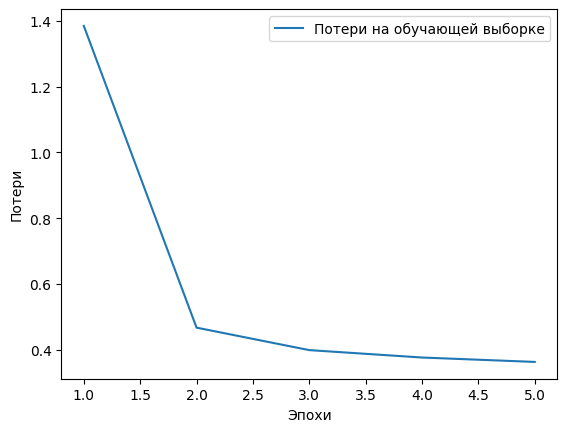

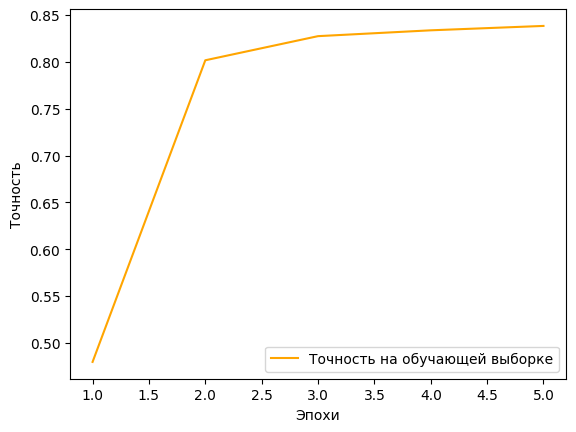

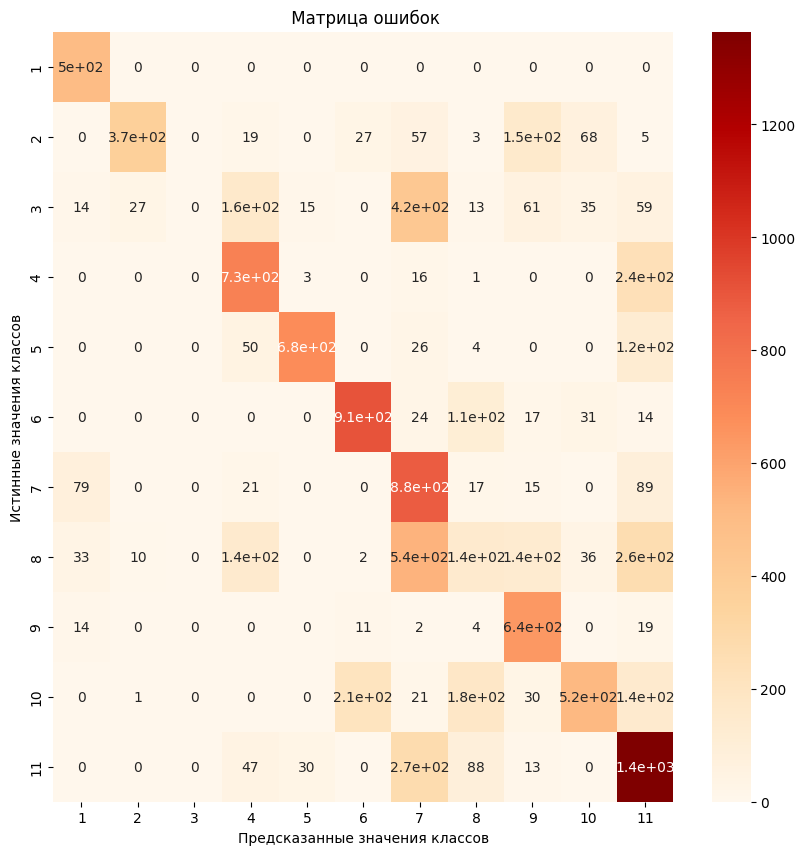

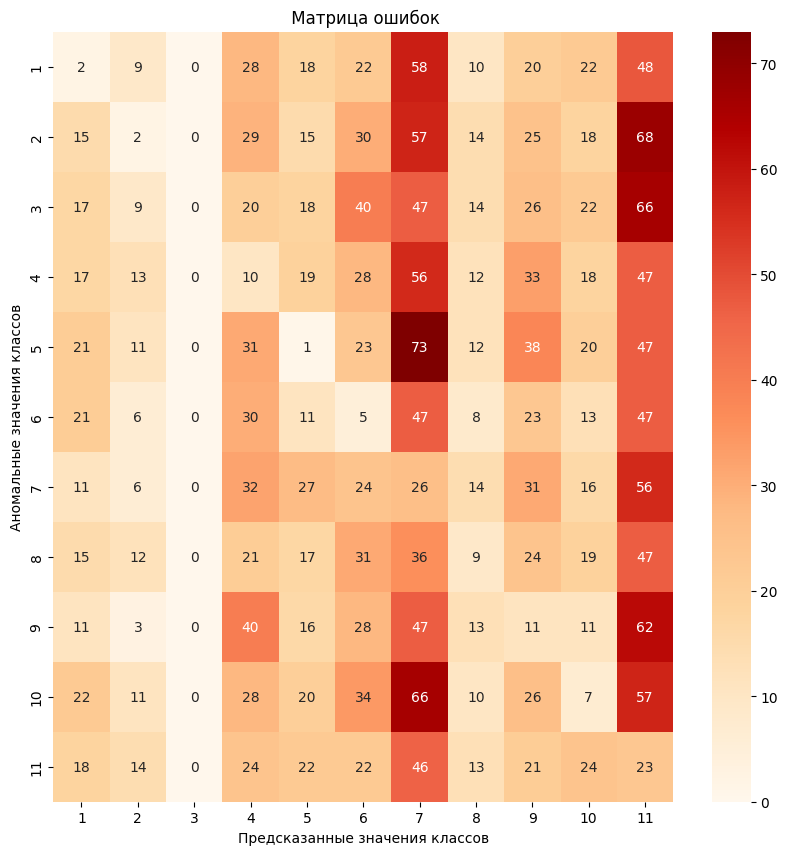

In [ ]:
loss_plt(history2)
accuracy_plt(history2)

plot_confusion_matrix(y_test,y,'Истинные','quiplet')
plot_confusion_matrix(y_test_anomalies[:anomalies_count],y[:anomalies_count],'Аномальные','quiplet')